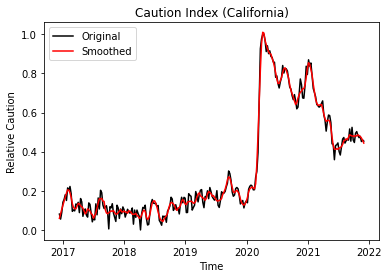

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.dates import DateFormatter
#import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#import datetime
from scipy import stats
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

%matplotlib inline

def mape(actual, fc): 
    actual, fc = np.array(actual), np.array(fc)
    return np.mean(np.abs((actual - fc) / actual)) * 100

def func_exp(t, tau):
    return np.exp(-t / tau)

df1 = pd.read_csv("C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\gtrend_caution.csv") 
df1.head()
df1['date'] = pd.to_datetime(df1.date)
df1.set_index("date", inplace = True)

fig, ax = plt.subplots()
ax.plot(df1.caution,'k-')
ax.set_xlabel("Time")
ax.set_ylabel("Relative Caution")
ax.set_title("Caution Index (California)")

# Baseline period 2017-2019 should be flat
df1['caution_sm'] = savgol_filter(df1.caution, window_length = 9, polyorder = 2)
ax.plot(df1.caution_sm,'r-')
ax.legend(['Original','Smoothed'])
plt.show()

df1['caution'] = df1['caution_sm']

In [266]:
# Check for any embedded NaN's that need to be filled
df_during[df_during.caution.isna()==True]
df1
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

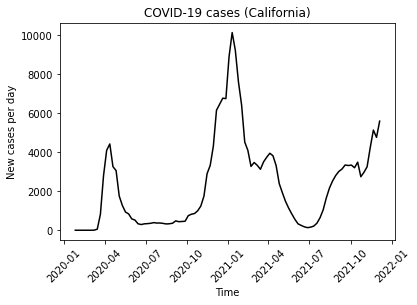

In [267]:
#Read in COVID case numbers, diff, plot, plot autoregression 

df2 = pd.read_csv('C:\\Users\\Ping\\Desktop\\Project\\COVID_prediction\\data\\United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv') 
df2['submission_date']=pd.to_datetime(df2.submission_date)
df2.set_index('submission_date', inplace = True)
df2 = df2[df2.state=="NY"]
df2.head()

# Remove commas and make data type int
#df2.new_case = df2.new_case.str.replace(',','').astype('int64', errors = 'raise')

# Aggregate to weekly
new_cases = df2.new_case.resample('W').mean()

plt.plot(new_cases,'k-')
plt.xlabel('Time')
plt.ylabel('New cases per day')
plt.title('COVID-19 cases (California)')
plt.xticks(rotation=45)


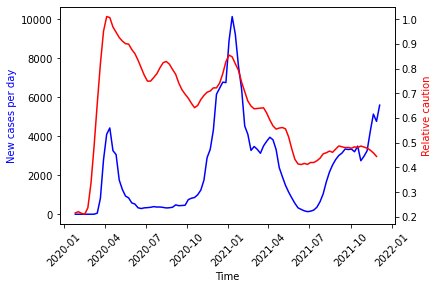

In [284]:
# Merge the full date range into previous
df_merged = pd.merge(df1,new_cases, how='inner',left_index=True,right_index=True)

# Coplot full range
fig,ax = plt.subplots()
ax.plot(new_cases,color='blue')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_merged.caution,color='red')
ax2.set_ylabel('Relative caution',color='red')

plt.show()

fig.savefig('Caution_and_new_cases.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

# Skip initial period of pandemic
df_during = df_merged['2020-05-20':]


C:\Users\Ping\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


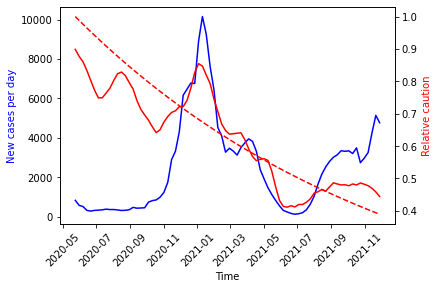

In [285]:
# Coplot 
fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='blue')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax2 = ax.twinx()
ax2.plot(df_during.caution,color='red')
ax2.set_ylabel('Relative caution',color='red')

np.random.seed(0)
t = np.arange(0,len(df_during.caution))
params, cov = curve_fit(func_exp, t, df_during.caution.values)
tau = params
y_fit = func_exp(t, tau)
# Doing a fit with amplitude and offset produces very large coefficients that doesn't reflect asymptoting,
# here we are forcing asymptoting

df_during.loc[:,'caution2'] = df_during.caution-y_fit

ax2.plot(df_during.index, y_fit, color='red',linestyle = '--')

plt.show()

fig.savefig('Caution_and_new_cases.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/3771548355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution2']= (df_during.caution2-df_during.caution2.min())/(df_during.caution2.max()-df_during.caution2.min())
C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/3771548355.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())


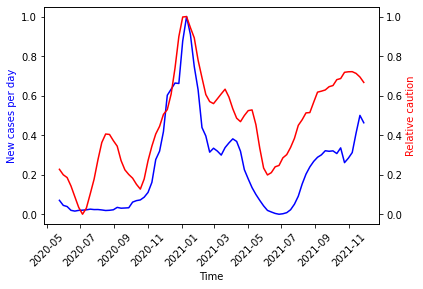

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/3771548355.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/3771548355.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)


In [286]:
# Remove down trend from caution
# m, b = np.polyfit(range(0,len(df_during.caution)),df_during.caution, 1)
# tvec = range(0,len(df_during.caution))
# df_during.caution = df_during.caution-(m*tvec+b)

# Max-min normalize
df_during['caution2']= (df_during.caution2-df_during.caution2.min())/(df_during.caution2.max()-df_during.caution2.min())
df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())

fig,ax = plt.subplots()
ax.plot(df_during.new_case,color='blue')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)
#ax.plot(df_during.new_case.diff(),color='black')

ax2 = ax.twinx()
ax2.plot(df_during.caution2,color='red')
ax2.set_ylabel('Relative caution',color='red')

plt.show()

epsilon = 0.01  # Prefer positive values and no -inf
df_during['log_caution'] = np.log(df_during['caution2']+epsilon)
df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)



In [287]:
print(sm.tsa.stattools.adfuller(df_during.caution2))
print(sm.tsa.stattools.adfuller(df_during.new_case))
# Both will need differencing
#print(sm.tsa.stattools.adfuller(df_during.caution2.diff().dropna()))
print(sm.tsa.stattools.adfuller(df_during.new_case.diff().dropna()))
# Caution needs a second round of differencing
print(sm.tsa.stattools.adfuller(df_during.caution2.diff().diff().dropna()))
print(sm.tsa.stattools.adfuller(df_during.new_case.diff().diff().dropna()))
# Stationary after second order differencing

#epsilon = 0.01  # Prefer positive values and no -inf
#df_during['log_caution'] = np.log(df_during['caution']+epsilon)
#df_during['log_new_case'] = np.log(df_during['new_case']+epsilon)

# Max-min normalize
#df_during['log_caution']= (df_during.log_caution-df_during.log_caution.min())/(df_during.log_caution.max()-df_during.log_caution.min())
#df_during['new_case']= (df_during.new_case-df_during.new_case.min())/(df_during.new_case.max()-df_during.new_case.min())

#np.random.seed(0)
#t = np.arange(0,len(df_during.log_caution))
#params, cov = curve_fit(func_exp, t, df_during.log_caution.values)
#tau = params
#y_fit = func_exp(t, tau)

#fig,ax3 = plt.subplots()
#ax3.plot(df_during.index,df_during.log_caution)
#ax3.plot(df_during.index, y_fit, color='red',linestyle = '--')
#plt.show()

#df_during.loc[:,'log_caution'] = df_during.log_caution-y_fit
#df_during['log_caution']= (df_during.log_caution-df_during.log_caution.min())/(df_during.log_caution.max()-df_during.log_caution.min())

print(sm.tsa.stattools.adfuller(df_during.log_caution))
print(sm.tsa.stattools.adfuller(df_during.log_new_case))


(-1.9512363282174685, 0.3083547193304036, 10, 69, {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}, -280.54097188568556)
(-2.183300688221456, 0.21236207242582011, 1, 78, {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}, -200.17594418003478)
(-4.692362376753159, 8.697725713365479e-05, 0, 78, {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}, -193.1410261136282)
(-4.7630544260401955, 6.396308886732895e-05, 8, 69, {'1%': -3.528889992207215, '5%': -2.9044395987933362, '10%': -2.589655654274312}, -262.56055488914507)
(-7.167712397144824, 2.857530430988091e-10, 2, 75, {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}, -177.3767154027663)
(-2.4897463314349277, 0.11798912799701922, 2, 77, {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}, -140.25432960954595)
(-2.761656743942023, 0.06396299682934703, 2, 77, {'1%': -3.518281134660583, '5

In [1254]:
pm.plot_acf(df_during.caution)

NameError: name 'pm' is not defined

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=27.915, Time=0.10 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=32.004, Time=0.31 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=32.499, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=29.840, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=31.885, Time=0.28 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=31.444, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=29.915, Time=0.08 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=30.623, Time=0.20 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=38.204, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=40.114, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=28.949, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=65.093, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=29.723, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=129.283, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=31.480, Time=0.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : A

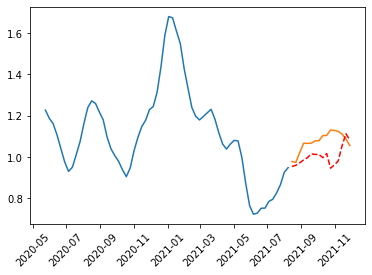

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -14.054
Date:                Mon, 06 Dec 2021   AIC                             36.109
Time:                        21:40:03   BIC                             44.744
Sample:                             0   HQIC                            39.511
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4690      0.101      4.664      0.000       0.272       0.666
ar.L1          1.1728      0.202      5.807      0.000       0.777       1.569
ar.L2         -0.4280      0.430     -0.995      0.320      -1.271       0.415
sigma2         0.0887      0.009     10.267      0.000       0.072       0.106
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               536.73
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [288]:
train, test = df_during[0:round(0.8*(len(df_during.log_caution)))], df_during[round(0.8*(len(df_during.log_caution))):]

model = auto_arima(df_during.log_caution,start_p=3, d=0, start_q=2, seasonal=False, trace=1, 
                   exogenous=np.reshape(df_during.log_new_case.values,(-1,1)),
                   stepwise=False, random=True, n_fits=50, random_state=1)

model.fit(train.log_caution, exogenous=np.reshape(train.log_new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.log_new_case.values,(-1,1)), n_periods=len(test))

forecast = pd.DataFrame(forecast,index = test.index,columns=['log_caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(np.exp(train.log_caution)-epsilon+y_fit[0:round(0.8*(len(df_during.log_caution)))])
plt.plot(np.exp(forecast.log_caution)-epsilon+y_fit[round(0.8*(len(df_during.log_caution))):])
plt.plot(np.exp(forecast.log_caution_pred)-epsilon+y_fit[round(0.8*(len(df_during.log_caution))):], color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

model.summary()


In [289]:
train, test = df_during[0:round(0.8*(len(df_during.caution)))], df_during[round(0.8*(len(df_during.caution))):]

model = auto_arima(df_during.caution,start_p=3, d=, start_q=1, seasonal=False, trace=1, 
                   stepwise=False, random=True, n_fits=50, random_state=0)

# Selects (2,1,2) and stable around (2,1,2) for CA
# Chooses (1,2,2) for NY


C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-490.432, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-486.537, Time=0.30 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-484.809, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-445.634, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-484.511, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-487.919, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-487.624, Time=0.33 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-485.736, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-471.501, Time=0.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-484.557, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-489.938, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-482.552, Time=0.15 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-488.342, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-487.808, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-489.827, Time=0.31 sec
 ARIMA(1,1

In [273]:
model = auto_arima(df_during.caution, start_p=2, d=1, start_q=2, exogenous=np.reshape(df_during.new_case.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
model.fit(train.caution, exogenous=np.reshape(train.new_case.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.new_case.values,(-1,1)), n_periods=len(test))

model.summary()
# Chooses () for CA
# Chooses (1,2,4) for NY

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-488.486, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-486.448, Time=0.28 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-482.865, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-444.528, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-484.915, Time=0.28 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-485.635, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-485.362, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-484.610, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-469.660, Time=0.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-483.182, Time=0.58 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-487.234, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-482.183, Time=0.23 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-486.399, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-484.920, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-478.267, Time=0.31 sec
 ARIMA(1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 200.437
Date:                Mon, 06 Dec 2021   AIC                           -388.874
Time:                        21:35:47   BIC                           -376.015
Sample:                             0   HQIC                          -383.816
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0074      0.005     -1.426      0.154      -0.018       0.003
x1            -0.0070      0.021     -0.340      0.734      -0.047       0.033
ma.L1          1.2915      0.176      7.321      0.000       0.946       1.637
ma.L2          1.3519      0.270      5.004      0.000       0.822       1.881
ma.L3          0.4855      0.188      2.586      0.010       0.117       0.854
sigma2      9.291e-05   2.24e-05      4.146      0.000     4.9e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.90   Prob(JB):                         0.84
Heteroskedasticity (H):               0.67   Skew:                            -0.09
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

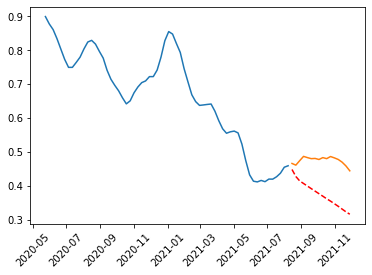

21.07540745227719

In [274]:
forecast = pd.DataFrame(forecast,index = test.index,columns=['caution_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(train.caution)
plt.plot(forecast.caution)
plt.plot(forecast.caution_pred, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

mape(forecast.caution, forecast.caution_pred)

In [275]:
model = auto_arima(df_during.new_case, start_p=2, d=2, start_q=2, exogenous=np.reshape(df_during.caution.values,(-1,1)),
                   trace=1, seasonal= False, stepwise=False, random=True, n_fits=30, random_state=0) 
model.fit(train.new_case, exogenous=np.reshape(train.caution.values,(-1,1)))
forecast = model.predict(exogenous=np.reshape(test.caution.values,(-1,1)), n_periods=len(test))

C:\Users\Ping\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-229.422, Time=0.39 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-230.225, Time=0.30 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=-222.886, Time=0.60 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-223.964, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-220.906, Time=0.19 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-229.858, Time=0.40 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-224.847, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-221.512, Time=0.10 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-223.216, Time=0.39 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-232.367, Time=0.40 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-226.514, Time=0.33 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-232.127, Time=0.34 sec
 ARIMA(1,2,1)(0,0,0)[0] i

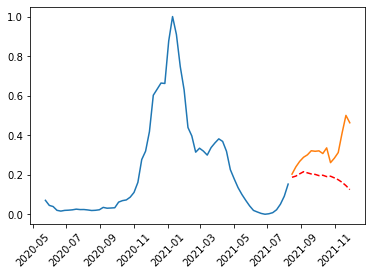

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(0, 2, 3)   Log Likelihood                  95.605
Date:                Mon, 06 Dec 2021   AIC                           -179.209
Time:                        21:36:07   BIC                           -166.446
Sample:                             0   HQIC                          -174.198
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.001     -0.360      0.719      -0.002       0.001
x1             0.9893      0.620      1.596      0.111      -0.226       2.205
ma.L1         -0.4258      0.117     -3.643      0.000      -0.655      -0.197
ma.L2         -0.2523      0.104     -2.415      0.016      -0.457      -0.048
ma.L3         -0.2513      0.116     -2.166      0.030      -0.479      -0.024
sigma2         0.0026      0.000      8.449      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                41.80
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [276]:
forecast = pd.DataFrame(forecast,index = test.index,columns=['new_case_pred'])
forecast = pd.concat([test,forecast],axis=1)
plt.plot(train.new_case)
plt.plot(forecast.new_case)
plt.plot(forecast.new_case_pred, color='red',linestyle='--')
plt.xticks(rotation=45)
plt.show()

model.summary()

In [ ]:
# Forecast next two weeks - don't forget to put exponential trend back in

In [1230]:
fit2 = ARIMA(endog=train.caution, exog=train.new_case, order=(2,1,1))
fit2.fit()
#fc = fit2.predict(len(test.new_case), exog=test.new_case)


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  raise ValueError('Non-date index index provided to'


(-4.692362376753159,
 8.697725713365479e-05,
 0,
 78,
 {'1%': -3.517113604831504,
  '5%': -2.8993754262546574,
  '10%': -2.5869547797501644},
 -193.1410261136282)

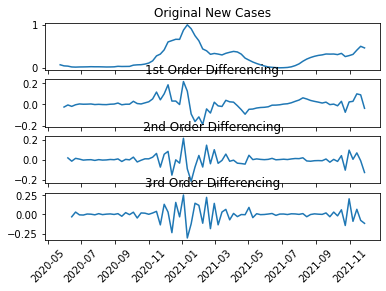

In [279]:
# Make stationary with differencing

fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.new_case); axes[0].set_title('Original New Cases')

# 1st Differencing
axes[1].plot(df_during.new_case.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.new_case.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.new_case.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

# Autocorrelogram on new cases
#plot_acf(df.value, ax=axes[0, 1])
#plot_acf(df.value.diff().dropna(), ax=axes[1, 1])
#plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

result = adfuller(df_during.new_case.diff().dropna())
result
# result[0] is test statistic, result[1] is p-val
# p-val < 0.05, so time series is stationary enough after one round of differencing, value gets smaller with more rounds
# visually looks reasonable after 2 rounds, no better with 3 rounds

#df_during['new_case_sta'] = df_during.new_case.diff()

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/2819642136.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_during['caution_sta'] = df_during.caution.diff()


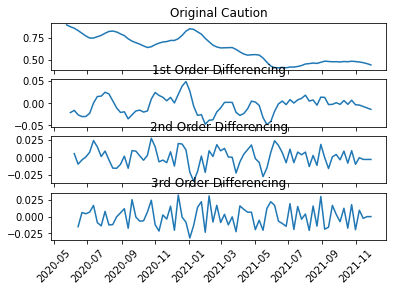

In [280]:
fig, axes = plt.subplots(4, 1, sharex=True)
axes[0].plot(df_during.caution); axes[0].set_title('Original Caution')

# 1st Differencing
axes[1].plot(df_during.caution.diff()); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
axes[2].plot(df_during.caution.diff().diff()); axes[2].set_title('2nd Order Differencing')

# 3rd Differencing
axes[3].plot(df_during.caution.diff().diff().diff()); axes[3].set_title('3rd Order Differencing')
plt.xticks(rotation=45)

result = adfuller(df_during.caution.diff().dropna())
result

df_during['caution_sta'] = df_during.caution.diff()

In [281]:
df_during2 = df_during.dropna()     # creating this helps indices stay in sync
df_sta = df_during2[['new_case_sta','caution_sta']]
train, test = df_sta[0:round(0.8*(len(df_sta.caution_sta)))], df_sta[round(0.8*(len(df_sta.caution_sta))):]
#train, test = df_sta[0:round(0.8*(len(df_during.log_caution)))], df_during[round(0.8*(len(df_sta.log_caution))):]
print(train.shape, test.shape)

for i in range(1,9):
    model = VAR(endog=train)
    model_fit = model.fit(i)
    print('maxlag :',i)
    print('AIC : ', model_fit.aic)

model_fit = model.fit(maxlags=12, ic='aic',verbose='true')
    
lag_order = model_fit.k_ar 

#model_fit = model.fit(lag_order)
model_fit = model.fit(lag_order)
model_fit.summary()



(63, 2) (16, 2)
maxlag : 1
AIC :  -14.72096040458622
maxlag : 2
AIC :  -15.061506546309047
maxlag : 3
AIC :  -15.101098099313324
maxlag : 4
AIC :  -15.003398142270312
maxlag : 5
AIC :  -14.912606793774506
maxlag : 6
AIC :  -14.809778279478149
maxlag : 7
AIC :  -14.662534031677643
maxlag : 8
AIC :  -14.697898191939528
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 3, BIC -> 2, FPE -> 3, HQIC ->  2>
Using 3 based on aic criterion


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Dec, 2021
Time:                     21:37:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.6124
Nobs:                     60.0000    HQIC:                  -14.9099
Log likelihood:           296.760    FPE:                2.77079e-07
AIC:                     -15.1011    Det(Omega_mle):     2.22206e-07
--------------------------------------------------------------------
Results for equation new_case_sta
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.010363         0.007002            1.480           0.139
L1.new_case_sta         0.519063         0.136608            3.800           0.000
L1.caution_sta          2.224510         0.60

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/2442357608.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['new_case_fc']=df_fc['new_case_sta_fc']
C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/2442357608.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=df_fc['caution_sta_fc']


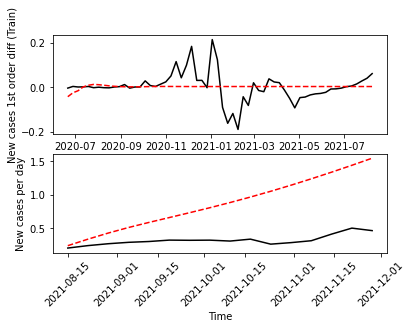

In [282]:
start = 0
forecast_input = train.values[start:start+lag_order]
fc_train = model_fit.forecast(forecast_input, steps=len(train)-start-lag_order)
df_fc_train = pd.DataFrame(fc_train, index = df_sta.index[start+lag_order:len(train)], columns = df_sta.columns + '_fc')
df_fc_train['new_case_sta'] = train.values[start+lag_order:,0]

forecast_input2 = train.values[-lag_order:]
fc = model_fit.forecast(y=forecast_input2, steps=len(test))
df_forecast = pd.DataFrame(fc, index=df_sta.index[-len(test):], columns=df_sta.columns + '_2d')

df_fc = df_forecast.copy()
columns = df_sta.columns
df_check = pd.DataFrame()

for col in columns: 
    col_orig = col.replace("_sta","")
    # De-difference 2nd
    df_fc[str(col)+'_1d'] = (df_during2[col_orig].iloc[len(train)-1]-df_during2[col_orig].iloc[len(train)-2]) + df_fc[str(col)+'_2d'].cumsum()
    
    # De-difference again
    df_fc[str(col)+'_fc'] = df_during2[col_orig].iloc[len(train)-1] + df_fc[str(col)+'_1d'].cumsum()

# Check
    df_check['new_case_1d'] = (df_during2['new_case'].iloc[len(train)-1]-df_during2['new_case'].iloc[len(train)-2]) + test["new_case_sta"].cumsum()
   
    df_check['new_case'] = df_during2['new_case'].iloc[len(train)-1] + df_check["new_case_1d"].cumsum()


test['new_case_fc']=df_fc['new_case_sta_fc']
test['caution_fc']=df_fc['caution_sta_fc']

fig,ax = plt.subplots(2,1)

ax[0].plot(df_fc_train.new_case_sta,color='black')
ax[0].set_ylabel('New cases 1st order diff (Train)',color='black')
ax[0].set_xlabel('Time')
ax[0].plot(df_fc_train.new_case_sta_fc,color='red',linestyle='--')

ax[1].plot(df_during2.new_case[round(0.8*(len(df_sta.caution_sta))):],color='black')
ax[1].set_ylabel('New cases per day',color='black')
ax[1].set_xlabel('Time')
plt.xticks(rotation=45)

ax[1].plot(test.new_case_fc,color='red',linestyle='--')
plt.show()


In [926]:
mape(df_during2.new_case[round(0.9*(len(df_sta.caution_sta))):], test.new_case_fc)

57.907524306296054

In [283]:
df_during_sub = df_during[['new_case','caution']].dropna()
train, test = df_during_sub[0:round(0.85*(len(df_during_sub.caution)))], df_during_sub[round(0.85*(len(df_during_sub.caution))):]
print(train.shape, test.shape)

model = VAR(endog=train)
model_fit = model.fit(maxlags=8, ic='aic',verbose='true',trend='ct')

lag_order = model_fit.k_ar  
#lag order 5 was selected
model_fit.summary()

(68, 2) (12, 2)
<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 3, FPE -> 4, HQIC ->  4>
Using 4 based on aic criterion


C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 06, Dec, 2021
Time:                     21:37:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.4728
Nobs:                     64.0000    HQIC:                  -14.8817
Log likelihood:           323.095    FPE:                2.65323e-07
AIC:                     -15.1475    Det(Omega_mle):     1.98459e-07
--------------------------------------------------------------------
Results for equation new_case
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.100265         0.240776           -0.416           0.677
trend               0.000875         0.001985            0.441           0.659
L1.new_case         1.430134         0.136016           10.514   

C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/1145738384.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['new_case_fc']=fc[:,0]
C:\Users\Ping\AppData\Local\Temp/ipykernel_9584/1145738384.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['caution_fc']=fc[:,1]


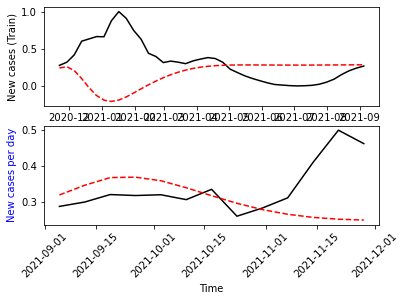

In [257]:
start = 25
forecast_input = train.values[start:start+lag_order]
fc_train = model_fit.forecast(forecast_input, steps=len(train)-start-lag_order)
df_fc_train = pd.DataFrame(fc_train, index = df_sta.index[start+lag_order:len(train)], columns = df_sta.columns + '_fc')
df_fc_train['new_case'] = train.values[start+lag_order:,0]

forecast_input2 = train.values[-lag_order:]
fc = model_fit.forecast(forecast_input2, steps=len(test.new_case))
test['new_case_fc']=fc[:,0]
test['caution_fc']=fc[:,1]

fig,ax = plt.subplots(2,1)

ax[0].plot(df_fc_train.new_case,color='black')
ax[0].set_ylabel('New cases (Train)',color='black')
ax[0].set_xlabel('Time')
ax[0].plot(df_fc_train.new_case_sta_fc,color='red',linestyle='--')

ax[1].plot(test.new_case,color='black')
ax[1].set_ylabel('New cases per day',color='blue')
ax[1].set_xlabel('Time')
plt.xticks(rotation=45)

ax[1].plot(test.new_case_fc,color='red',linestyle='--')
plt.show()


In [929]:
mape(test.new_case, test.new_case_fc)


45.67397032473607

C:\Users\Ping\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


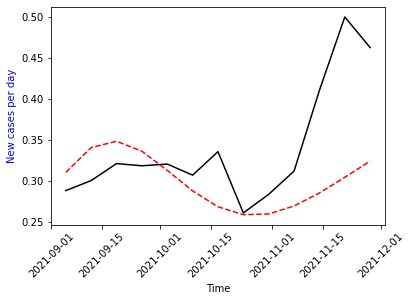

In [258]:
model2 = sm.tsa.VARMAX(endog=train, order = (2,0), trend='ct')
model2_fit = model2.fit(maxiter=5000, disp=True)
model2_fit.summary()

# Does not converge for 5, works horribly for other values

# Only can forecast from end of sample
fc = model2_fit.forecast(steps=len(test.new_case))

fig,ax = plt.subplots()

ax.plot(test.new_case,color='black')
ax.set_ylabel('New cases per day',color='blue')
ax.set_xlabel('Time')
plt.xticks(rotation=45)

ax.plot(fc.new_case,color='red',linestyle='--')
plt.show()


In [259]:
df_during = df_during.dropna()

grangercausalitytests(df_during[['caution_sta','new_case_sta']],maxlag=12)

# Case levels predict caution


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0063  , p=0.9369  , df_denom=79, df_num=1
ssr based chi2 test:   chi2=0.0065  , p=0.9355  , df=1
likelihood ratio test: chi2=0.0065  , p=0.9356  , df=1
parameter F test:         F=0.0063  , p=0.9369  , df_denom=79, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7088  , p=0.0731  , df_denom=76, df_num=2
ssr based chi2 test:   chi2=5.7739  , p=0.0557  , df=2
likelihood ratio test: chi2=5.5774  , p=0.0615  , df=2
parameter F test:         F=2.7088  , p=0.0731  , df_denom=76, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3046  , p=0.0023  , df_denom=73, df_num=3
ssr based chi2 test:   chi2=17.4397 , p=0.0006  , df=3
likelihood ratio test: chi2=15.7766 , p=0.0013  , df=3
parameter F test:         F=5.3046  , p=0.0023  , df_denom=73, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5674  , p=0.0105  , df_d

{1: ({'ssr_ftest': (0.006299993669073317, 0.9369370574266617, 79.0, 1),
   'ssr_chi2test': (0.006539233934987494, 0.935548893267262, 1),
   'lrtest': (0.006538973207625531, 0.9355501753546263, 1),
   'params_ftest': (0.006299993669092558, 0.9369370574266178, 79.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.708754619399292, 0.07305326761397762, 76.0, 2),
   'ssr_chi2test': (5.773924320298492, 0.0557453009465139, 2),
   'lrtest': (5.5774178752014905, 0.061500563746572375, 2),
   'params_ftest': (2.7087546193992624, 0.07305326761397928, 76.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (5.304573624613867, 0.0023059137102759523, 73.0, 3),
   'ssr_chi2test': (17.43969410831956, 0.0005738185552729087, 3),
   'lrtest': (15.776562400027387, 0.0012600813220364714, 3),
   'params_ftest': (5.304573624613856, 0.0023059137102759814, 73.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

In [242]:
grangercausalitytests(df_during[['new_case_sta','caution_sta']],maxlag=12)

# Caution predicts case loads only for lag 1, trends towards significance again at lag 5-6


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.0961 , p=0.0000  , df_denom=79, df_num=1
ssr based chi2 test:   chi2=19.8213 , p=0.0000  , df=1
likelihood ratio test: chi2=17.7530 , p=0.0000  , df=1
parameter F test:         F=19.0961 , p=0.0000  , df_denom=79, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.8003 , p=0.0001  , df_denom=76, df_num=2
ssr based chi2 test:   chi2=23.0216 , p=0.0000  , df=2
likelihood ratio test: chi2=20.2621 , p=0.0000  , df=2
parameter F test:         F=10.8003 , p=0.0001  , df_denom=76, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0790  , p=0.0001  , df_denom=73, df_num=3
ssr based chi2 test:   chi2=26.5611 , p=0.0000  , df=3
likelihood ratio test: chi2=22.9353 , p=0.0000  , df=3
parameter F test:         F=8.0790  , p=0.0001  , df_denom=73, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.6896  , p=0.0005  , df_d

{1: ({'ssr_ftest': (19.09610342777681, 3.742847252518259e-05, 79.0, 1),
   'ssr_chi2test': (19.82127191237593, 8.503109791495294e-06, 1),
   'lrtest': (17.752983018242503, 2.5152279893042255e-05, 1),
   'params_ftest': (19.096103427776807, 3.742847252518259e-05, 79.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (10.800251462431653, 7.442835080903904e-05, 76.0, 2),
   'ssr_chi2test': (23.021588643604314, 1.0021334156677265e-05, 2),
   'lrtest': (20.26209378908777, 3.9823757783010774e-05, 2),
   'params_ftest': (10.800251462431639, 7.442835080903986e-05, 76.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (8.07900044118222, 0.00010192636554540837, 73.0, 3),
   'ssr_chi2test': (26.56109734087305, 7.276254441013676e-06, 3),
   'lrtest': (22.93534959469821, 4.165561294108277e-05, 3),
   'params_ftest': (8.079000441182197, 0.00010192636554541098, 73.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0

In [ ]:
plt_acf(dataset[i], lags = 50)
  plt.title('ACF for %s' % i)